<a href="https://colab.research.google.com/github/Pranav-Dinesh/UGProject/blob/master/Project_Pneumothorax_Group_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Kernel for Pneumothorax Segmentation
Before the advent of deep learning, feature engineering had to be be performed i.e. to divide the image by color, contrast, etc. Deep learning allows us to automate this process. However, this makes deep learning computationally exhaustive. Hence we use GPUs to make computations faster.

# 0. Install Kaggle, Pydicom

The first step is to install the following libraries:
- FastAI for fast.ai functions
- kaggle for the datasets, and
- pydicom for working on DICOM images (which is the form of input)

In [1]:
## Colab
! curl -s https://course.fast.ai/setup/colab | bash

! pip install kaggle --upgrade
! pip install pydicom

Updating fastai...
Done.
Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)
     |████████████████████████████████| 35.1MB 89kB/s 


Deep learning works sufficiently well in the presence of a huge dataset and GPUs. GPUs offer simple, multi-tasking and parallel optimization with its many cores. This makes GPUs suitable for graphics processing on today's high resolution multi-pixel screen since each pixel needs the same processing at every point.

To check the GPU memory in Colab:
- GPUtil is a Python module for getting the GPU status from NVIDA GPUs using nvidia-smi.
- PSUtil is a cross-platform module for Python in order to keep a record of system utilization and running process

In [2]:
# # memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=c446940baf3e3bd48536bca10888c2218b5599e90c796964e95706d9f493d31c
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 160.5 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


To clear the memory:

In [0]:
!kill -9 -1

# 1. Import Library

Now that the necessary libraries were downloaded, we import them for our code.
- Numpy is used to make use of their NumPy arrays which are used for multi-dimensional arrays and matrices (called tensors).
- Pandas offers functions for data manipulation and analysis.
- OS library allows functions taht could perform OS functions like creating directories, etc.
- The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell. This is important to obtain images that match a certain naming.
- Both pyplot and cm of matplotlib are used for plotting purposes (like colour maps)
- Path is used for directory purposes
- The vision module of the fastai library contains all the necessary functions to define a Dataset and train a model for computer vision tasks. The four submodules are: vision.image for defining an image object, vision.transform for data augmentation, vision.data for the definition of ImageDataBunch, and vision.learner for building and fine-tuning models with a pretrained CNN.


In [0]:
import math
import numpy as np
import pandas as pd

import os
import glob

#!pip install pydicom
import pydicom

from pathlib import Path
from matplotlib import cm
from matplotlib import pyplot as plt

import fastai
from fastai.vision import *

In [4]:
fastai.__version__

'1.0.60'

# 2. Preparing Path for Datasets from Kaggle

Specify the path of the Config File and Dataset to be on Google Drive.

Mount Google Drive to retrieve the Config File from our personal Google Drive. On running the cell below, a link will appear. Login, press Approve and Copy Authorization Code into the box below and press Enter.

For the purpose of **progressive resizing**, we will use data available in different sizes of 128, 256, 512, and 1024.

In [5]:
# Addresses of Datasets on Kaggle
dataset = 'siim-acr-pneumothorax-segmentation'
dataset2 = 'jesperdramsch/siim-acr-pneumothorax-segmentation-data'
dataset3 = 'iafoss/siimacr-pneumothorax-segmentation-data-128'
dataset4 = 'iafoss/siimacr-pneumothorax-segmentation-data-256'
dataset5 = 'iafoss/siimacr-pneumothorax-segmentation-data-512'
dataset6 = 'iafoss/siimacr-pneumothorax-segmentation-data-1024'
dataset_test = 'ivanzhovannik/siim_stage2_png'

# # Google Colab
config_path = Path('/content/drive')
data_path_base = Path('/content/datasets/')
data_path = data_path_base/dataset
data_path2 = data_path_base/dataset2
data_path3 = data_path_base/dataset3
data_path4 = data_path_base/dataset4
data_path5 = data_path_base/dataset5
data_path6 = data_path_base/dataset6
data_path_test = data_path_base/dataset_test

from google.colab import drive
drive.mount(str(config_path))
os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/My Drive/.kaggle"

# VM
config_path = Path(os.getenv("HOME"))
data_path = config_path/"datasets"/dataset
data_path2 = config_path/"datasets"/dataset2
data_path3 = config_path/"datasets"/dataset3
data_path4 = config_path/"datasets"/dataset4
data_path5 = config_path/"datasets"/dataset5
data_path6 = config_path/"datasets"/dataset6
data_path_test = config_path/"datasets"/dataset_test

data_path.mkdir(parents=True, exist_ok=True)
os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/.kaggle"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 3. Dataset

Now, we shall download the datasets, which is divided into XRays of various sizes, test-data, train-data, etc.

We will need a kaggle.json file from our Kaggle account to download the dataset.

Upload the kaggle.json file when prompted. We shall create a .kaggle folder in the root.

Download the dataset from Kaggle and unzip it. Note: it might already by unzipped.

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pranavdinesh","key":"888dded826ffd110d8d425a8f394e53f"}'}

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [9]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 68 Feb 18 15:10 kaggle.json
{"username":"pranavdinesh","key":"888dded826ffd110d8d425a8f394e53f"}

In [10]:
!kaggle competitions download -c {dataset} -p "{data_path}"
!kaggle datasets download {dataset2} -p "{data_path2}" --unzip
!kaggle datasets download {dataset3} -p "{data_path3}" --unzip
!kaggle datasets download {dataset4} -p "{data_path4}" --unzip
!kaggle datasets download {dataset5} -p "{data_path5}" --unzip
!kaggle datasets download {dataset6} -p "{data_path6}" --unzip
!kaggle datasets download {dataset_test} -p "{data_path_test}" --unzip

  0% 0.00/150k [00:00<?, ?B/s]
100% 150k/150k [00:00<00:00, 21.0MB/s]
  0% 0.00/153k [00:00<?, ?B/s]
100% 153k/153k [00:00<00:00, 48.6MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 50.0MB/s]
  0% 0.00/153k [00:00<?, ?B/s]
100% 153k/153k [00:00<00:00, 46.7MB/s]
  0% 0.00/113k [00:00<?, ?B/s]
100% 113k/113k [00:00<00:00, 97.6MB/s]
  0% 0.00/110k [00:00<?, ?B/s]
100% 110k/110k [00:00<00:00, 115MB/s]
  0% 0.00/89.8k [00:00<?, ?B/s]
100% 89.8k/89.8k [00:00<00:00, 84.7MB/s]
  0% 0.00/114k [00:00<?, ?B/s]
100% 114k/114k [00:00<00:00, 100MB/s]
  0% 0.00/140k [00:00<?, ?B/s]
100% 140k/140k [00:00<00:00, 46.4MB/s]
  0% 0.00/130k [00:00<?, ?B/s]
100% 130k/130k [00:00<00:00, 105MB/s]
  0% 0.00/138k [00:00<?, ?B/s]
100% 138k/138k [00:00<00:00, 130MB/s]
  0% 0.00/97.3k [00:00<?, ?B/s]
100% 97.3k/97.3k [00:00<00:00, 83.4MB/s]
  0% 0.00/106k [00:00<?, ?B/s]
100% 106k/106k [00:00<00:00, 84.8MB/s]
  0% 0.00/155k [00:00<?, ?B/s]
100% 155k/155k [00:00<00:00, 49.4MB/s]
  0% 0.00/111k [00

Now, unzip the file downloaded from Kaggle competition.

In [11]:
! unzip -q {data_path}/siim-acr-pneumothorax-segmentation.zip -d {data_path}
! unzip -q {data_path}/stage_2_images.zip -d {data_path}/stage_2_images
! unzip -q {data_path}/stage_2_train.csv.zip -d {data_path}

unzip:  cannot find or open /root/datasets/siim-acr-pneumothorax-segmentation/siim-acr-pneumothorax-segmentation.zip, /root/datasets/siim-acr-pneumothorax-segmentation/siim-acr-pneumothorax-segmentation.zip.zip or /root/datasets/siim-acr-pneumothorax-segmentation/siim-acr-pneumothorax-segmentation.zip.ZIP.
unzip:  cannot find or open /root/datasets/siim-acr-pneumothorax-segmentation/stage_2_images.zip, /root/datasets/siim-acr-pneumothorax-segmentation/stage_2_images.zip.zip or /root/datasets/siim-acr-pneumothorax-segmentation/stage_2_images.zip.ZIP.


We shall also import a function (provided by Google) for converting the label-data in Run-Length Encoding (RLE) to mask format. Note that RLE is a lossless data compression method that counts the number of occurences of a distinct value (in this case, pixels that contribute to the mask).

In [0]:
import sys
sys.path.insert(0, str(data_path))

from mask_functions import *

# 4. Handling the Data

## 4.1 DICOM Image

We shall explore the information provided with the Chest XRays as shown:

In [0]:
def show_dcm_info(dataset): #to display information about the patient
    print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset: #if image is available in the DICOM file
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()


A DICOM file contains both images and metadata in the same file.
In the above code, plt.figure creates a figure object with the dimensions as the parameters passed. plt.imshow creates a drawing on the array but does not display the image yet. This is done by the plt.show command. The cmap = plt.cm.bone changes the default colormap as well as the colormap of the current image if there is one (Note that "bone" is a color command).

Now, call the defined functions:

Filename.........: /root/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.331.1517875162.418468/1.2.276.0.7230010.3.1.3.8323329.331.1517875162.418467/1.2.276.0.7230010.3.1.4.8323329.331.1517875162.418469.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 7fe9e13d-a17a-4f68-898f-41130d2ce69b, 
Patient id..........: 7fe9e13d-a17a-4f68-898f-41130d2ce69b
Patient's Age.......: 25
Patient's Sex.......: F
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 119528 bytes
Pixel spacing....: [0.168, 0.168]


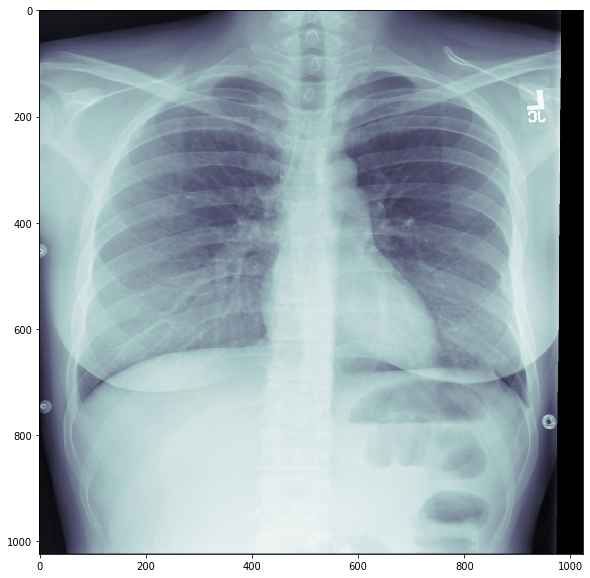

In [15]:
for file_path in glob.glob(str(data_path2/'pneumothorax/dicom-images-train/*/*/*.dcm')):
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    plot_pixel_array(dataset)
    break # Comment this out to see all

Here, we display many files at the same time:

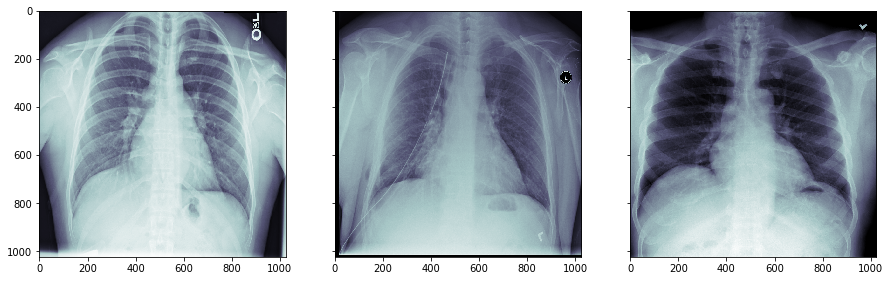

In [16]:
start = 22   # Starting index of images
num_img = 3 # Total number of images to show

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*5,5))
for q, file_path in enumerate(glob.glob(str(data_path2/'pneumothorax/dicom-images-train/*/*/*.dcm'))[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)
    #show_dcm_info(dataset)
    
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)


Observe the label that comes in RLE format, as shown in the EncodedPixels column.

A label of -1 means a normal lung i.e. no pneumothorax case.

In [17]:
df = pd.read_csv(data_path2/'train-rle.csv', index_col=0) 
df.head() #to display first few entries only of the csv file

,EncodedPixels
ImageId,
1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090,-1
1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137,-1
1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [18]:
df.shape #to display the shape of the array that represents the csv file.

(11582, 1)

That means there are a total of 11582 images in the set.

## 4.2 Mask

Use the derived function to convert RLE to a 1024 x 1024 mask.

In [19]:
mask = rle2mask(df.loc['1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709'][0].strip(), 1024, 1024).T
a = mask.sum(axis=1)
a = mask.sum(axis=0)
a.argmax() #returns the indices of the maximum value among an axis

mask[105:115, 300:310]

array([[  0.,   0.,   0.,   0., ...,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., ...,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., ...,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., ...,   0.,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0.,   0., ..., 255., 255., 255., 255.],
       [  0.,   0.,   0., 255., ..., 255., 255., 255., 255.],
       [  0., 255., 255., 255., ..., 255., 255., 255., 255.],
       [255., 255., 255., 255., ..., 255., 255., 255., 255.]])

To be clear, we will convert it to transparent for overlay with X-Ray film images.

In [20]:
mask_rgba = mask/255
mask_rgba = np.repeat(mask_rgba[:, :, np.newaxis], 4, axis=2)
mask_rgba[:, :, [1,2]] = 0
mask_rgba[:, :, 3] = mask_rgba[:, :, 3]*0.7

mask_rgba[105:115, 300:310, 0]

array([[0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., ..., 1., 1., 1., 1.],
       [0., 0., 0., 1., ..., 1., 1., 1., 1.],
       [0., 1., 1., 1., ..., 1., 1., 1., 1.],
       [1., 1., 1., 1., ..., 1., 1., 1., 1.]])

To show the mask of an image:

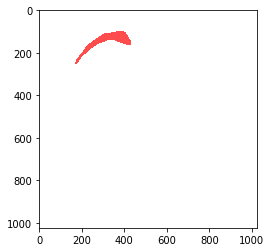

In [21]:
plt.imshow(mask_rgba)

## 4.3 DICOM Image and Mask

To show the XRay image with the Pneumothorax mask in red:

In [0]:
start = 43   # Starting index of images
num_img = 6 # Total number of images to show

1.2.276.0.7230010.3.1.4.8323329.10630.1517875224.627381.dcm
Nothing to see
1.2.276.0.7230010.3.1.4.8323329.3350.1517875177.426289.dcm
Nothing to see
1.2.276.0.7230010.3.1.4.8323329.2091.1517875171.121121.dcm
Nothing to see
1.2.276.0.7230010.3.1.4.8323329.4704.1517875184.223889.dcm


KeyError: ignored

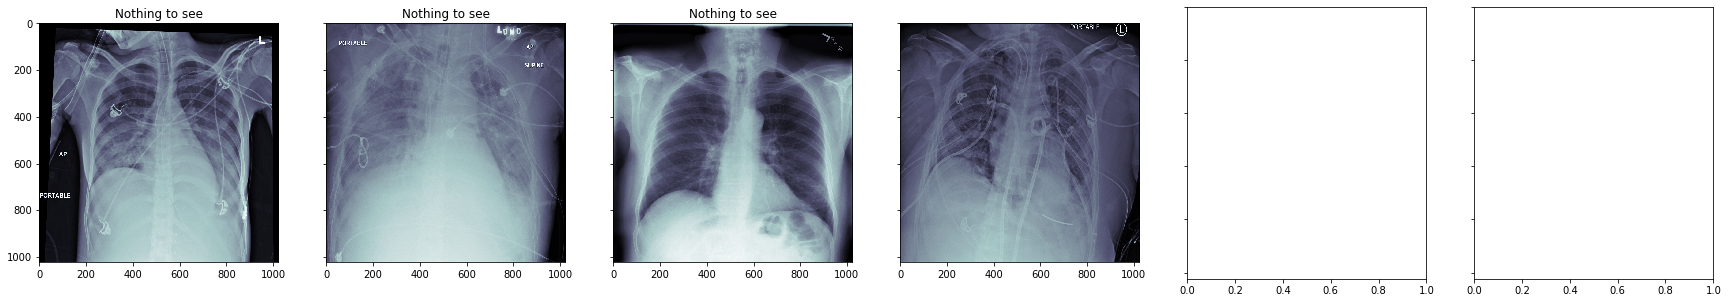

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*5,5))
for q, file_path in enumerate(glob.glob(str(data_path2/'pneumothorax/dicom-images-train/*/*/*.dcm'))[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)
    print(file_path.split('/')[-1])
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    fn = file_path.split('/')[-1][:-4]
    rle = df.loc[fn][0].strip()
    # print(rle)
    if rle != '-1': #if there is a pneumothorax case
        print('See Marker')
        mask = rle2mask(rle, 1024, 1024).T
        ax[q].set_title('See Marker') # Normal Mask
        ax[q].imshow(mask, alpha=0.3, cmap="rainbow")
        
        # Make alpha mask
        mask_rgba = mask/255
        mask_rgba = np.repeat(mask_rgba[:, :, np.newaxis], 4, axis=2)
        mask_rgba[:, :, [1,2]] = 0
        mask_rgba[:, :, 3] = mask_rgba[:, :, 3]*0.4

        ax[q].imshow(mask_rgba)
    else:
        print('Nothing to see')
        ax[q].set_title('Nothing to see')


# 5. Data Pipeline

For convenience, we shall convert the files provided through the Kaggle dataset to png files.

We set the batchsize and the location of the path.
Current deep neural network algorithms are based on Mini-Batch Stochastic Gradient Optimization. The # data samples we enter for the model for a single batch is the hyperparameter. 

**[NOTE 1]:**
In cases with large data such as high resolution images, it is preferred to reduce the batch size, especially in cases with GPU memory limitations. This will avoid out-of-memory errors.

**[NOTE 2]:**
This decrease in batch size will also affect other parameters. For instance, smaller batch size implies longer training times, but less memory use. Generally, it is advised to keep batch sizes <= 32

**Reference: https://arxiv.org/abs/1804.07612 (*Revisiting Small Batch Training for Deep Neural Networks*)**

In [0]:

bs=128      #batch size - hyperparameter to be tested

SZ = 128 #size could be 128, 256, 512, 1024
path = data_path3

Class and Function Declarations used in Data Pipelining for Semantic Segmentation are as follows (reference only):

In [0]:
# Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): 
      return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

Why do we use a DataBunch class?  We use an object of this class for modelling purposes.

# Architecture of DataBunch API
## Dataset (from PyTorch)
The Dataset class in PyTorch defines two important methods: __getitem__ and __len__. This class doesn't actually help you create the class, but rather _defines_ what your dataset must do: the getitem method retrives a dataset item, while the len method returns the size of the actual dataset.

## DataLoader (from PyTorch)
Having a dataset is not enough to train a model. For our GPU to work in parallel, we divide our dataset into mini-batches. We use DataLoader class to create these mini-batches.
A DataLoader takes an object of Dataset in its constructor. It selects data items at random, creates a batch of the size as given by user and delivers it to the GPU for modeling.

## DataBunch API
Having the mini-batches isn't enough to train the model. Validation is equally important to know how well we are performing through the model. For training, we split the dataset to three sets: __train__, __validation__, and __test__ (optional). For this purpose, we use a fastAi class called DataBunch, which binds both a training dataloader and a testing dataloader together. So when you create a DataBunch, you're basically giving it a training set data loader and a validation set data loader.

The API for DataBlock is as follows:

      data = #Where to find the data? -> in path and its subfolders
       (ImageList.from_folder(path)     
        #How to split in train/valid? -> use the folders
        .split_by_folder()              
        #How to label? -> depending on the folder of the filenames
        .label_from_folder()            
        #Optionally add a test set (here default name is test)
        .add_test_folder()              
        #Data augmentation? -> use tfms with a size of 64
        .transform(tfms, size=64)       
        #Finally? -> use the defaults for conversion to ImageDataBunch
        .databunch()) 

Use the DataBlock API to create a DataBunch. We then train the model using a Train / Validation Split of 80/20. Each pixel is a Binary Classification (0/1), do Data Augmentation everything except Flip Vertical and normalize with imagenet_stats.

Note that the normalization is performed based on imagenet_stats i.e. normalizing according to the imagenet's mean & standard deviation.

__Why normalize?__ The scale of the data has an effect on the magnitude of the gradient for the weights. If the gradient is big, you should reduce the learning rate. However you usually have different gradient magnitudes in a same batch. Normalizing the image to smaller pixel values is a cheap price to pay while making easier to tune an optimal learning rate for input images.
(Reference:https://arthurdouillard.com/post/normalization/)

In [0]:
# Create databunch
data = (SegmentationItemList.from_folder(path=path/'train')#[:500]
        .split_by_rand_pct(0.2, seed=1234)
        .label_from_func(lambda x : str(x).replace('train', 'masks'), classes=[0, 1])
        .add_test((data_path_test).ls(), label=None)
        .transform(get_transforms(), size=SZ, tfm_y=True)
        .databunch(path=Path('.'), bs=bs)
        .normalize(imagenet_stats))

We check the size of the training set and validation set as split above:

In [28]:
len(data.train_ds), len(data.valid_ds)

(9638, 2409)

9368 + 2409 = 11777

The data for the first batch is as follows:

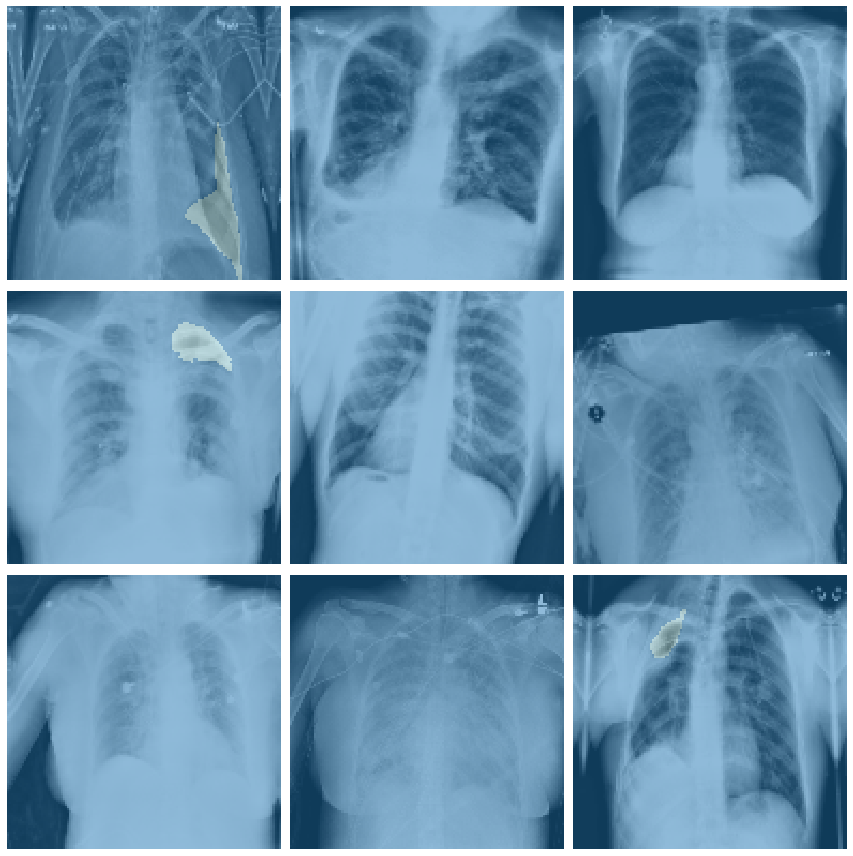

In [30]:
data.show_batch(rows=3, figsize=(12, 12))

# 6. Model

## 6.1 Dice Metric

Dice or Sørensen – Dice coefficient is a statistic used to measure the similarity of two sample data. The equation is as follows:

$$DSC =  \frac{2 |X \cap Y|}{|X|+ |Y|} = \frac{2 TP}{2 TP + FP + FN} $$

## 6.2 U-Net and ResNet34

Reference: https://gilberttanner.com/blog/fastai-image-segmentation

The U-NET architecture consists of two paths. The contraction path (the __encoder__) and the expansion path (the __decoder__).

The encoder extracts features which contain information about what is in an image using convolutional and pooling layers.

Whilst encoding the size of the feature map gets reduced. The decoder is then used to recover the feature map size for the segmentation image, for which it uses Up-convolution layers.

Because the decoding process loses some of the higher level features the encoder learned, the U-NET has __skip connections__. That means that the outputs of the encoding layers are passed directly to the decoding layers so that all the important pieces of information can be preserved.

In [32]:
learn = unet_learner(data, models.resnet34, metrics=[dice], self_attention=True, 
                     blur=True, norm_type=NormType.Weight, 
                     callback_fns=ShowGraph).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


The encoder-decoder network has been specified to be resnet34. The accuracy function passed is Dice.

In [33]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
__________________________________________________

# 7. Train

With our model ready to go we can now search for a fitting learning rate and then start training our model. 

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 1.58E-03


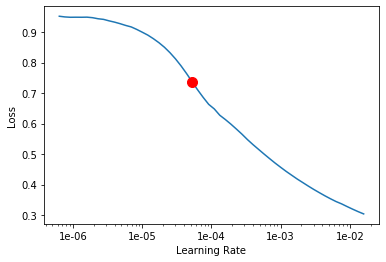

In [34]:
learn.lr_find() #finds the learning rate
learn.recorder.plot(suggestion=True, skip_last=1) #plots the learning rate graph

A very small learning rate can lead to very slow training, while a very large learning rate can hinder convergence as the loss function fluctuates around the minimum, or even diverges.

## 7.1 Train Last Layer

In [0]:
lr = 1e-3 #to pick a learning rate

epoch,train_loss,valid_loss,dice,time
0,0.049736,0.018207,0.778746,01:11
1,0.022879,0.015076,0.778746,01:09
2,0.016916,0.013102,0.778746,01:09


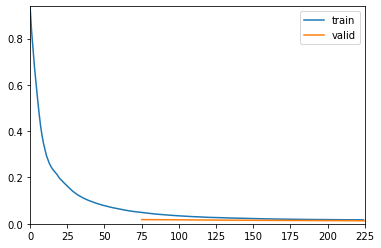

In [36]:
learn.fit_one_cycle(3, max_lr=lr, wd=1e-3, pct_start=0.8) #now, train the model

Standardly only the decoder is unfrozen, which means that our pretrained encoder didn’t receive any training yet so we will now show some results and then train the whole model.

In [0]:
learn.save('03b-unet-resnet34-128-1') #save the model

In [0]:
learn.load('03b-unet-resnet34-128-1');

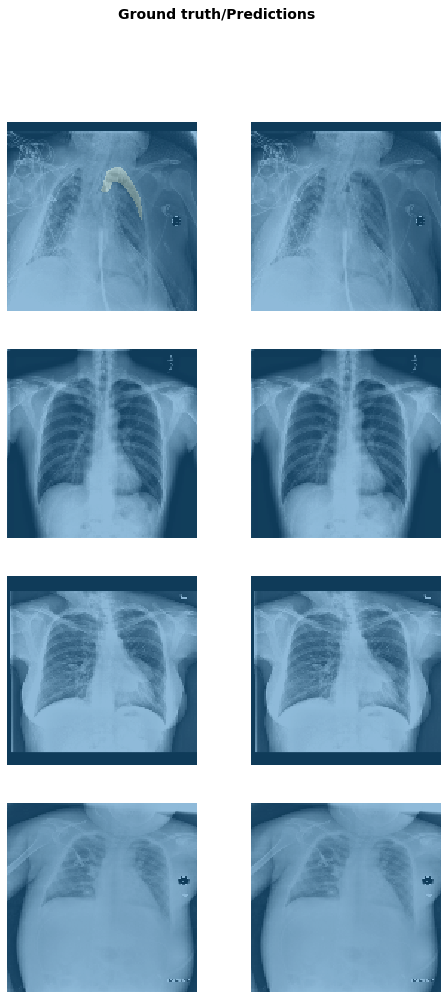

In [40]:
learn.show_results(rows=4, figsize=(8, 16))

## 7.2 Unfreeze and Train Whole Model

In [0]:
learn.unfreeze() #unfreeze all layers

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06
Min loss divided by 10: 3.98E-05


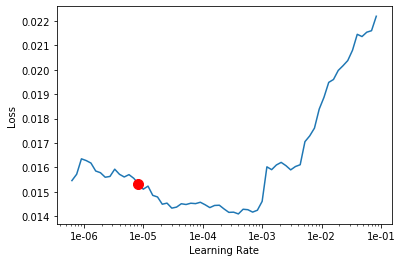

In [42]:
learn.lr_find()
learn.recorder.plot(suggestion=True, skip_last=0)

In [0]:
lr = slice(3e-6, 3e-4)

epoch,train_loss,valid_loss,dice,time
0,0.014136,0.013271,0.778746,01:11
1,0.013610,0.013079,0.769394,01:11
2,0.033056,0.015609,0.778750,01:11
3,0.021576,0.015404,0.420479,01:11
4,0.025718,0.019210,0.228644,01:12
5,0.049028,0.017546,0.778746,01:11
6,0.026975,0.021612,0.595507,01:12
7,0.027260,0.019278,0.660393,01:12
8,0.019272,0.015773,0.550761,01:12


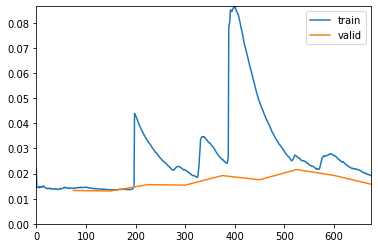

In [44]:
learn.fit_one_cycle(9, max_lr=lr, wd=1e-3, pct_start=0.7)

In [0]:
learn.save('03b-unet-resnet34-128-2')

In [0]:
learn.load('03b-unet-resnet34-128-2');

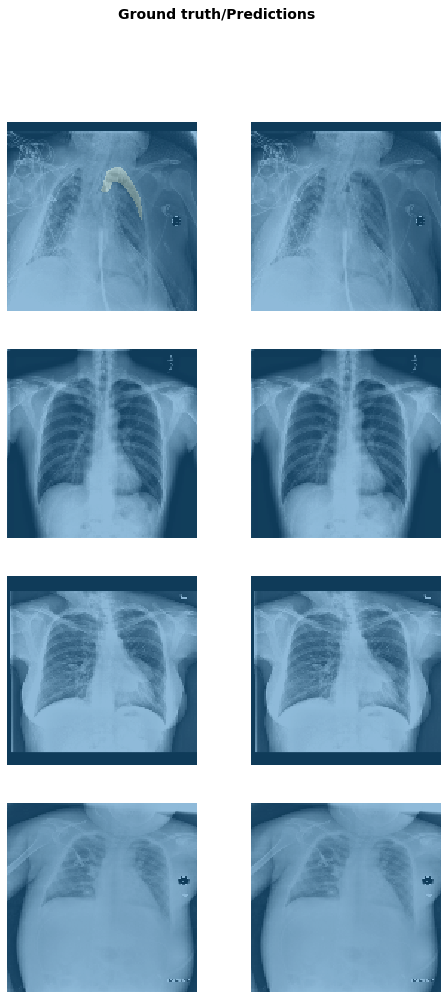

In [47]:
learn.show_results(rows=4, figsize=(8, 16))

## 7.3 Increase Image size to 256 and Train Last Layer

In [48]:
learn.destroy()
gc.collect()

this Learner object self-destroyed - it still exists, but no longer usable


0

In [0]:
bs=32

SZ = 256
path = data_path4

This time we normalize with 1 Batch data from our own Dataset instead of using imagenet_stats.

In [0]:
# Create databunch
data = (SegmentationItemList.from_folder(path=path/'train')#[:500]
        .split_by_rand_pct(0.2, seed=1234)
        .label_from_func(lambda x : str(x).replace('train', 'masks'), classes=[0, 1])
        .add_test((data_path_test).ls(), label=None)
        .transform(get_transforms(), size=SZ, tfm_y=True)
        .databunch(path=Path('.'), bs=bs)
        .normalize())

In [0]:
learn = unet_learner(data, models.resnet34, metrics=[dice], 
                     self_attention=True, blur=True, norm_type=NormType.Weight, 
                     callback_fns=ShowGraph).to_fp16()

In [0]:
learn.load('03b-unet-resnet34-128-2')
learn.freeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=1)

In [0]:
lr = 3e-4

epoch,train_loss,valid_loss,dice,time
0,0.015486,0.013347,0.668535,04:41
1,0.014247,0.011659,0.770115,04:23
2,0.011951,0.011608,0.735081,04:23
3,0.010512,0.009813,0.771516,04:23


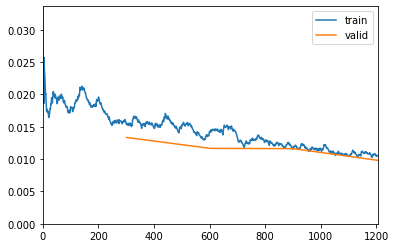

In [55]:
learn.fit_one_cycle(4, max_lr=lr, wd=1e-3, pct_start=0.8)

In [0]:
learn.save('03b-unet-resnet34-256-1')

In [0]:
learn.load('03b-unet-resnet34-256-1');

In [0]:
learn.show_results(rows=4, figsize=(8, 16))

## 7.4 Unfreeze and Train Whole Model with 256

In [0]:
learn.unfreeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=0)

In [0]:
lr = slice(3e-6, 1e-4)

In [0]:
learn.fit_one_cycle(10, max_lr=lr, wd=1e-3, pct_start=0.7)

In [0]:
learn.save('03b-unet-resnet34-256-2')

In [0]:
learn.load('03b-unet-resnet34-256-2');

In [0]:
# learn.show_results(rows=4, figsize=(8, 16))

## 7.5 Increase Image size to 512 and Train Last Layer

In [0]:
learn.destroy()
gc.collect()

In [0]:
bs=7

SZ = 512
path = data_path5

In [0]:
# path.ls()

In [0]:
# Create databunch
data = (SegmentationItemList.from_folder(path=path/'train')#[:500]
        .split_by_rand_pct(0.2, seed=1234)
        .label_from_func(lambda x : str(x).replace('train', 'masks'), classes=[0, 1])
        .add_test((data_path_test).ls(), label=None)
        .transform(get_transforms(), size=SZ, tfm_y=True)
        .databunch(path=Path('.'), bs=bs)
        .normalize())

In [0]:
learn = unet_learner(data, models.resnet34, metrics=[dice], 
                     self_attention=True, blur=True, norm_type=NormType.Weight, 
                     callback_fns=ShowGraph).to_fp16()

In [0]:
learn.load('03b-unet-resnet34-256-2')
learn.freeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=1)

In [0]:
lr = 3e-4

In [0]:
learn.fit_one_cycle(4, max_lr=lr, wd=1e-3, pct_start=0.8)

In [0]:
learn.save('03b-unet-resnet34-512-1')

In [0]:
learn.load('03b-unet-resnet34-512-1');

In [0]:
# learn.show_results(rows=4, figsize=(8, 16))

## 7.6 Unfreeze and Train Whole Model with 512

In [0]:
learn.unfreeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=0)

In [0]:
lr = slice(3e-6, 1e-4)

In [0]:
learn.fit_one_cycle(8, max_lr=lr, wd=1e-3, pct_start=0.7)

In [0]:
learn.save('03b-unet-resnet34-512-2')

In [0]:
learn.load('03b-unet-resnet34-512-2');

In [0]:
# learn.show_results(rows=4, figsize=(8, 16))

In [0]:
learn.fit_one_cycle(2, max_lr=lr, wd=1e-3, pct_start=0.7)

## 7.7 Data Augmentation Annealing

Before Infer, we will train with data that is not done. Data Augmentation is supplemented. Data augmentation is often preferred when training data is insufficent. Data augmentation is the process of recycling images by obtaining different orientations of the images to obtain more training images.


In [0]:
learn.destroy()
gc.collect()

In [0]:
bs=7

SZ = 512
path = data_path5

In [0]:
# path.ls()

In [0]:
transform_none = [[], []]
# Create databunch
data = (SegmentationItemList.from_folder(path=path/'train')#[:500]
        .split_by_rand_pct(0.01, seed=1234)
        .label_from_func(lambda x : str(x).replace('train', 'masks'), classes=[0, 1])
        .add_test((data_path_test).ls(), label=None)
        .transform(transform_none, size=SZ, tfm_y=True)
        .databunch(path=Path('.'), bs=bs)
        .normalize())

In [0]:
learn = unet_learner(data, models.resnet34, metrics=[dice], 
                     self_attention=True, blur=True, norm_type=NormType.Weight, 
                     callback_fns=ShowGraph).to_fp16()

In [0]:
learn.load('03b-unet-resnet34-512-2');


In [0]:
learn.unfreeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=1)

In [0]:
lr = slice(3e-6, 1e-4)

In [0]:
learn.fit_one_cycle(4, max_lr=lr, wd=1e-3, pct_start=0.7)

In [0]:
learn.save('03b-unet-resnet34-512-3')

In [0]:
learn.load('03b-unet-resnet34-512-3');

In [0]:
# learn.show_results(rows=4, figsize=(8, 16))

# 8. Make a Prediction

Now that the training is complete, we predict for Pneumothorax in the validation set (= 20%)

In [0]:
# Predictions for the validation set
preds, ys = learn.get_preds()
preds = preds[:,1,...]
ys = ys.squeeze()

In [0]:
preds.shape, ys.shape

In [0]:
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union)

Determine threshold for Dice:

In [0]:
# Find optimal threshold
dices = []
thrs = np.arange(0.01, 1, 0.01)
for i in progress_bar(thrs):
    preds_m = (preds>i).long()
    dices.append(dice_overall(preds_m, ys).mean())
dices = np.array(dices)

In [0]:
best_dice = dices.max()
best_thr = thrs[dices.argmax()]

plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()

See results in Pneumothorax will be seen as Image Segmentation in yellow-green color. Lung area with Pneumothorax compared with Label from the sample data in Dataset.

Will see that our models are accurately diagnosed

In [0]:
# Plot some samples
rows = 5
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]
for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')